In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

In [4]:
#load data object: prenatal skin only, post qc

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
adata = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [5]:
adata

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'joint_annotation_20220202'
  

In [6]:
print(list(adata.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LYVE1-hi LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating 

# DEGs across PCW in keratinocytes

In [7]:
all_keratinocytes = ['Periderm', 
'Immature basal', 
'Immature suprabasal', 
'POSTN+ basal',
'DPYSL2+ basal', 
'Suprabasal IFE',
'Outer root sheath', 
'Companion layer',
'Placode/matrix',
'Inner root sheath',
'Cuticle/cortex',]

In [8]:
all_ker = adata[adata.obs['joint_annotation_20220202'].isin(all_keratinocytes)]

In [9]:
all_ker

View of AnnData object with n_obs × n_vars = 1469 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'joint_annotation_202202

In [10]:
all_ker.obs['joint_annotation_20220202'] = all_ker.obs['joint_annotation_20220202'].cat.reorder_categories([
'Periderm', 
'Immature basal', 
'Immature suprabasal', 
'POSTN+ basal',
'DPYSL2+ basal', 
'Suprabasal IFE',
'Outer root sheath', 
'Companion layer',
'Placode/matrix',
'Inner root sheath',
'Cuticle/cortex',     
])

In [11]:
print(list(all_ker.obs['pcw'].unique()))

[9, 7, 8, 16, 15, 11, 14]


In [12]:
new_bins = {
'7' : '7-8',
'8' : '7-8',
'9' : '9-11',
'10' : '9-11',
'11' : '9-11',
'12' : '12-16',
'13' : '12-16',
'14' : '12-16',
'15' : '12-16',
'16' : '12-16'
}

In [13]:
new_bins

{'7': '7-8',
 '8': '7-8',
 '9': '9-11',
 '10': '9-11',
 '11': '9-11',
 '12': '12-16',
 '13': '12-16',
 '14': '12-16',
 '15': '12-16',
 '16': '12-16'}

In [14]:
all_ker.obs['pcw_binned'] = all_ker.obs['pcw'].astype(str).map(new_bins)
all_ker.obs['pcw_binned'] = all_ker.obs['pcw_binned'].astype('category')
all_ker.obs['pcw_binned'].value_counts()

12-16    1237
7-8       185
9-11       47
Name: pcw_binned, dtype: int64

In [15]:
all_ker.obs['pcw_binned'] = all_ker.obs['pcw_binned'].cat.reorder_categories([
'7-8',
'9-11',
'12-16'
])

In [33]:
# sctk _markers function
%run /home/jovyan/_markers.py

In [34]:
kdata_marker_stats_pcw = calc_marker_stats(all_ker, 'pcw_binned')

In [35]:
kdata_marker_stats_pcw[2]

,top_frac_group,top_frac,frac_diff,max_frac_diff,top_mean_group,top_mean,mean_diff,max_mean_diff
FO538757.2,12-16,0.299111,0.061273,0.128898,7-8,0.093593,0.006174,0.050288
AP006222.2,9-11,0.127660,0.003335,0.088048,9-11,0.063755,0.008357,0.050172
RP4-669L17.2,9-11,0.021277,0.018043,0.021277,9-11,0.021277,0.019288,0.021277
RP4-669L17.10,9-11,0.021277,0.018851,0.021277,9-11,0.013480,0.011278,0.013480
RP5-857K21.4,7-8,0.005405,0.001363,0.005405,7-8,0.004645,0.001744,0.004645
...,...,...,...,...,...,...,...,...
AC007325.2,12-16,0.001617,0.001617,0.001617,12-16,0.001237,0.001237,0.001237
AL354822.1,7-8,0.005405,0.002980,0.005405,12-16,0.001316,0.000187,0.001316
AC004556.1,12-16,0.055780,0.050375,0.055780,12-16,0.018425,0.014409,0.018425
AC240274.1,9-11,0.063830,0.026643,0.053019,9-11,0.020578,0.005809,0.017213


In [36]:
kdata_markers_pcw = filter_marker_stats(kdata_marker_stats_pcw[2], max_next_frac=0.2, min_mean_diff=0.3, how='or')

In [37]:
kdata_markers_pcw = kdata_markers_pcw[~kdata_markers_pcw.index.str.startswith(('MT-', 'RPS', 'MIR'))]
kdata_markers_pcw = kdata_markers_pcw[~kdata_markers_pcw.index.str.match('^RP\d{1,2}-')]

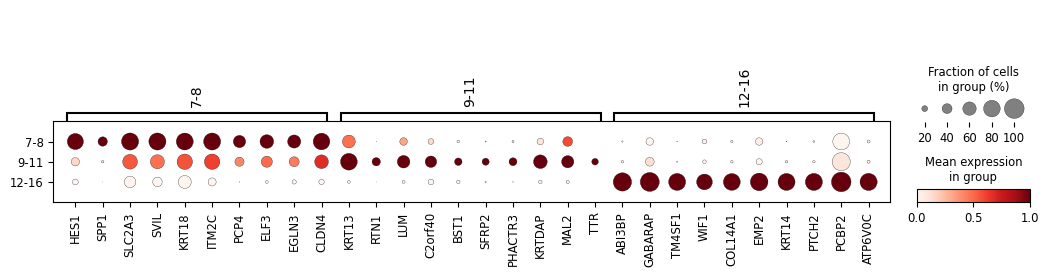

In [38]:
plot_markers(all_ker, 'pcw_binned', kdata_markers_pcw, n_genes=10, standard_scale='var')
#save='panel2_marker_genes.pdf')

In [39]:
deg_kdata_pcw = test_markers(all_ker, kdata_markers_pcw, 'pcw_binned', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [30]:
#deg_kdata_pcw.to_csv('/home/jovyan/projects/skin/fetal_skin/csv files/marker_plots/keratinocytes_markers_pcw_2c_29072022.csv')

In [40]:
deg_kdata_pcw

,genes,cluster,top_frac,frac_diff,max_frac_diff,top_mean_group,top_mean,mean_diff,max_mean_diff,logfoldchanges,pvals,pvals_adj
0,HES1,7-8,0.767568,0.448419,0.571125,7-8,0.360387,0.270673,0.319489,4.290513,1.827905e-50,1.612858e-49
1,SPP1,7-8,0.372973,0.309143,0.370548,7-8,0.206556,0.185557,0.205715,7.679738,4.317876e-16,8.635751e-16
2,SLC2A3,7-8,0.832432,0.151581,0.341729,7-8,0.496317,0.176103,0.391392,3.637381,1.575229e-51,1.524415e-50
3,SVIL,7-8,0.832432,0.194135,0.453289,7-8,0.442657,0.175018,0.335001,2.719060,8.471327e-51,7.941869e-50
4,KRT18,7-8,0.821622,0.098217,0.249269,7-8,0.531219,0.160259,0.369569,2.862719,8.545591e-45,5.826539e-44
...,...,...,...,...,...,...,...,...,...,...,...,...
3645,CENPM,12-16,0.206144,0.057208,0.114252,12-16,0.079201,0.000375,0.035912,NaN,NaN,NaN
3646,ICK,12-16,0.160065,0.032405,0.111416,12-16,0.040591,0.000225,0.026557,NaN,NaN,NaN
3647,AHCYL1,12-16,0.300728,0.057484,0.109238,12-16,0.076063,0.000119,0.027654,NaN,NaN,NaN
3648,TFDP1,12-16,0.211803,0.055046,0.126696,12-16,0.057903,0.000011,0.014196,NaN,NaN,NaN


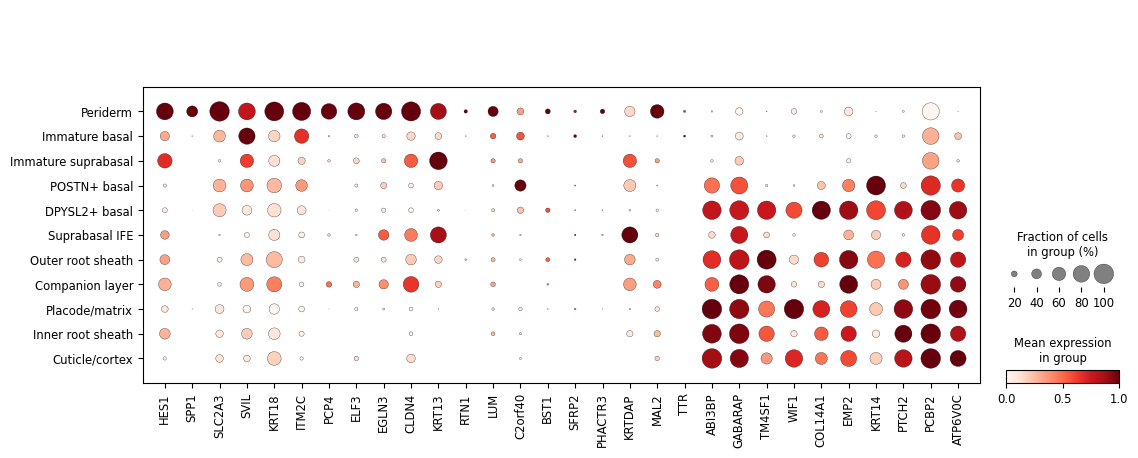

In [42]:
sc.pl.dotplot(all_ker, ['HES1', 'SPP1', 'SLC2A3', 'SVIL', 'KRT18', 'ITM2C', 'PCP4', 'ELF3', 'EGLN3', 'CLDN4',
                     'KRT13', 'RTN1', 'LUM', 'C2orf40', 'BST1', 'SFRP2', 'PHACTR3', 'KRTDAP', 'MAL2', 'TTR',
                     'ABI3BP', 'GABARAP', 'TM4SF1', 'WIF1', 'COL14A1', 'EMP2', 'KRT14', 'PTCH2', 'PCBP2', 'ATP6V0C'],
              groupby=['joint_annotation_20220202'], standard_scale='var')

#sc.pl.dotplot(all_ker, ['HES1', 'SPP1', 'SLC2A3', 'SVIL', 'KRT18', 'ITM2C', 'PCP4', 'ELF3', 'EGLN3', 'CLDN4',
#                     'KRT13', 'RTN1', 'LUM', 'C2orf40', 'BST1', 'SFRP2', 'PHACTR3', 'KRTDAP', 'MAL2', 'TTR',
#                     'ABI3BP', 'GABARAP', 'TM4SF1', 'WIF1', 'COL14A1', 'EMP2', 'KRT14', 'PTCH2', 'PCBP2', 'ATP6V0C'],
#              groupby=['joint_annotation_20220202'], standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/Fig2C_partb.pdf')

# DEGs between IRS and ORS trajectories

In [16]:
keep_keratinocytes = ['POSTN+ basal', 'DPYSL2+ basal', 'Companion layer', 
                     'Outer root sheath', 'Placode/matrix', 'Cuticle/cortex', 'Inner root sheath']

In [17]:
kdata = adata[adata.obs['joint_annotation_20220202'].isin(keep_keratinocytes)]

In [18]:
kdata

View of AnnData object with n_obs × n_vars = 1206 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'joint_annotation_202202

In [19]:
kdata.obs['joint_annotation_20220202'] = kdata.obs['joint_annotation_20220202'].cat.reorder_categories([
'Outer root sheath',
'Companion layer',
'DPYSL2+ basal',
'POSTN+ basal',
'Placode/matrix', 
'Inner root sheath',
'Cuticle/cortex',
])

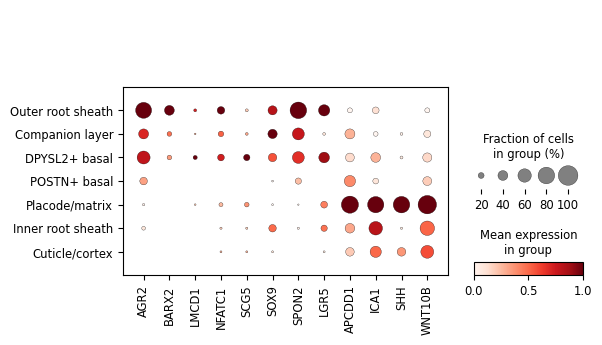

In [23]:
sc.pl.dotplot(kdata, var_names=['AGR2', 'BARX2', 'LMCD1', 'NFATC1', 'SCG5', 'SOX9', 'SPON2', 'LGR5', 
                                 'APCDD1', 'ICA1', 'SHH', 'WNT10B'], 
              groupby=['joint_annotation_20220202'], standard_scale='var')
#.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/trajectory_dotplot_17062022.pdf')
#('/home/jovyan/projects/skin/fetal_skin/figures/figures/trajectory_dotplot_17062022.pdf')
#'KRT79', 'KRT75', 'KRT6A', 'KRT6B',
#show()

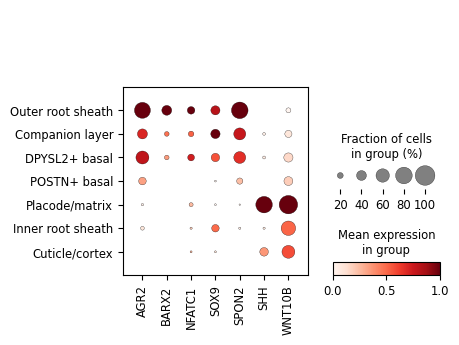

In [24]:
sc.pl.dotplot(kdata, var_names=['AGR2', 'BARX2', 'NFATC1', 'SOX9', 'SPON2',
                                'SHH', 'WNT10B'], 
            groupby=['joint_annotation_20220202'], standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/trajectory_dotplot_28072023.pdf')

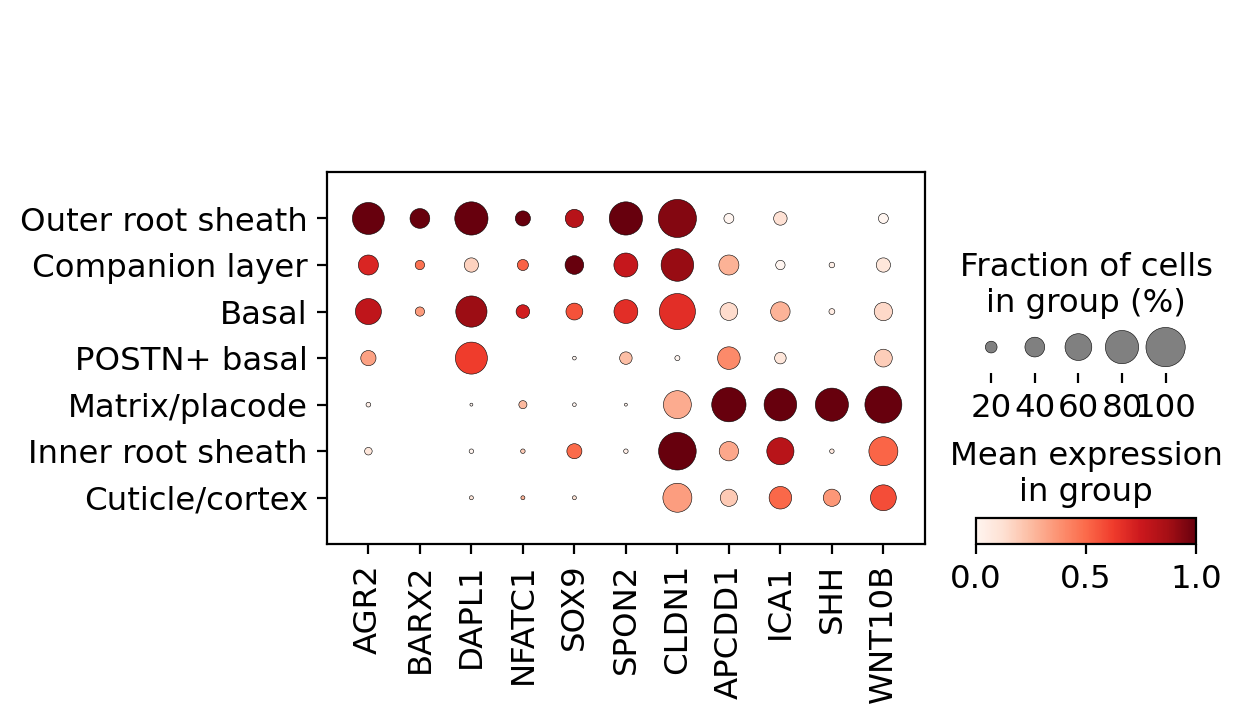

In [25]:
# with CLDN1 added
#sc.pl.dotplot(kdata2, var_names=['AGR2', 'BARX2', 'DAPL1', 'NFATC1', 'SOX9', 'SPON2', 'CLDN1',
#                                 'APCDD1', 'ICA1', 'SHH', 'WNT10B'], 
#              groupby=['joint_annotation_20220202'], standard_scale='var')

# Signaling pathways dotplot

In [43]:
f_kerfib2=[
'DPYSL2+ basal', 
'Outer root sheath', 
'Companion layer',
'Placode/matrix',
'Inner root sheath',
'Cuticle/cortex', 
'Pre-dermal condensate', 
'Dermal condensate', 
'Dermal papilla']

In [44]:
adata_fkerfib2 = adata[adata.obs['joint_annotation_20220202'].isin(f_kerfib2)]

In [45]:
adata_fkerfib2

View of AnnData object with n_obs × n_vars = 34534 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [48]:
adata_fkerfib2.obs['joint_annotation_20220202'] = adata_fkerfib2.obs['joint_annotation_20220202'].cat.reorder_categories([
'DPYSL2+ basal', 
'Outer root sheath', 
'Companion layer',
'Placode/matrix',
'Inner root sheath',
'Cuticle/cortex', 
'Pre-dermal condensate', 
'Dermal condensate', 
'Dermal papilla'
])

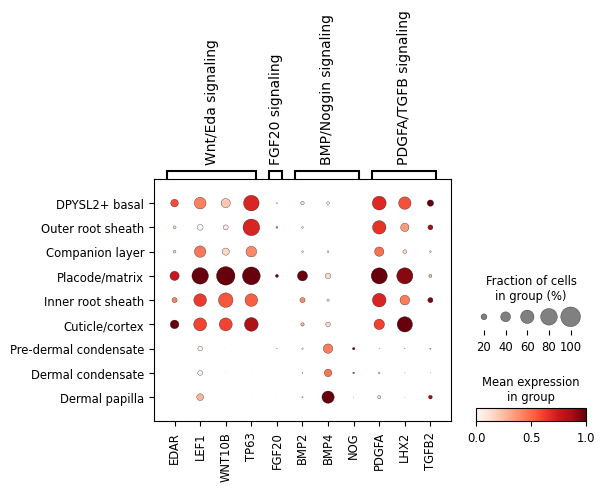

In [49]:
signal_genes = {'Wnt/Eda signaling': ['EDAR', 'LEF1', 'WNT10B', 'TP63'],
           'FGF20 signaling': 'FGF20',
           'BMP/Noggin signaling': ['BMP2', 'BMP4', 'NOG'], 
           'PDGFA/TGFB signaling': ['PDGFA', 'LHX2', 'TGFB2']}

sc.pl.dotplot(adata_fkerfib2, signal_genes, groupby=['joint_annotation_20220202'], 
              standard_scale='var')

#sc.pl.dotplot(adata_fkerfib2, signal_genes, groupby=['joint_annotation_20220202'], 
#              standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/hair_signalling_12122022.pdf')

# Comparison of CXCL12 expression

In [7]:
hair_fib = ['HOXC5+ early fibroblast',   
'Pre-dermal condensate', 
'Dermal condensate', 
'Dermal papilla']

In [8]:
hairfib = adata[adata.obs['joint_annotation_20220202'].isin(hair_fib)]

In [9]:
hairfib

View of AnnData object with n_obs × n_vars = 48649 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'joint_annotation_20220

In [10]:
print(list(hairfib.obs['joint_annotation_20220202'].unique()))

['Pre-dermal condensate', 'HOXC5+ early fibroblast', 'Dermal condensate', 'Dermal papilla']


In [11]:
hairfib.obs['joint_annotation_20220202'] = hairfib.obs['joint_annotation_20220202'].cat.reorder_categories([
'HOXC5+ early fibroblast',   
'Pre-dermal condensate', 
'Dermal condensate', 
'Dermal papilla'
])

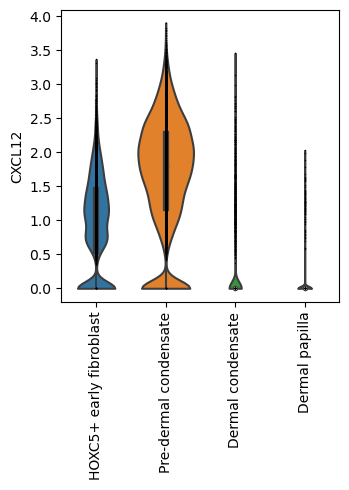

In [12]:
with rc_context({'figure.figsize' : (4,4)}):
    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='joint_annotation_20220202', scale='count', 
                 inner='box', rotation=90, jitter=False)
    
#with rc_context({'figure.figsize' : (4,4)}):
#    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='joint_annotation_20220202', scale='count', 
#                 inner='box', rotation=90, jitter=False, save='_CXCL12_byfib_28042023.pdf')

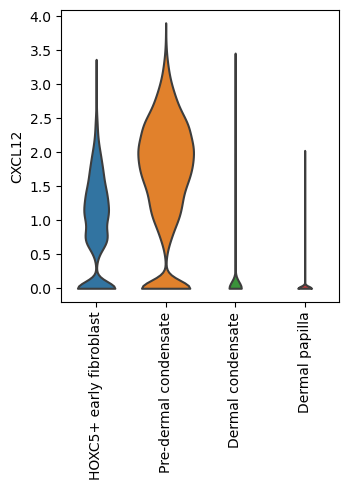

In [15]:
with rc_context({'figure.figsize' : (4,4)}):
    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='joint_annotation_20220202', scale='count', 
                 rotation=90, jitter=False, stripplot=False, save='_CXCL12_byfib_nobox.pdf')
    
#with rc_context({'figure.figsize' : (4,4)}):
#    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='joint_annotation_20220202', scale='count', 
#                 inner='box', rotation=90, jitter=False, save='_CXCL12_byfib_28042023.pdf')

In [16]:
print(list(hairfib.obs['pcw'].unique()))

[8, 9, 10, 7, 13, 16, 12, 15, 11, 14]


In [17]:
new_bins = {
'7' : '7-8',
'8' : '7-8',
'9' : '9-11',
'10' : '9-11',
'11' : '9-11',
'12' : '12-13',
'13' : '12-13',
'14' : '14-16',
'15' : '14-16',
'16' : '14-16'
}

In [18]:
new_bins

{'7': '7-8',
 '8': '7-8',
 '9': '9-11',
 '10': '9-11',
 '11': '9-11',
 '12': '12-13',
 '13': '12-13',
 '14': '14-16',
 '15': '14-16',
 '16': '14-16'}

In [19]:
hairfib.obs['pcw_binned'] = hairfib.obs['pcw'].astype(str).map(new_bins)
hairfib.obs['pcw_binned'] = hairfib.obs['pcw_binned'].astype('category')
hairfib.obs['pcw_binned'].value_counts()

7-8      16033
14-16    15375
9-11     13378
12-13     3863
Name: pcw_binned, dtype: int64

In [20]:
hairfib.obs['pcw_binned'] = hairfib.obs['pcw_binned'].cat.reorder_categories([
'7-8',
'9-11',
'12-13',
'14-16'
])

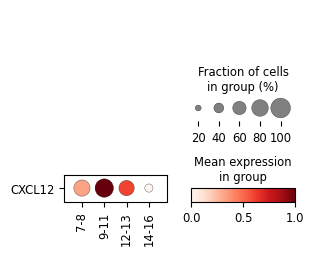

In [21]:
sc.pl.dotplot(hairfib, var_names=['CXCL12'], groupby=['pcw_binned'], swap_axes=True, standard_scale='var')

In [22]:
new_pcw = {
'7' : '7',
'8' : '8',
'9' : '9',
'10' : '10',
'11' : '11',
'12' : '12',
'13' : '13',
'14' : '14',
'15' : '15',
'16' : '16'
}

In [23]:
new_pcw

{'7': '7',
 '8': '8',
 '9': '9',
 '10': '10',
 '11': '11',
 '12': '12',
 '13': '13',
 '14': '14',
 '15': '15',
 '16': '16'}

In [24]:
hairfib.obs['pcw_new'] = hairfib.obs['pcw'].astype(str).map(new_pcw)
hairfib.obs['pcw_new'] = hairfib.obs['pcw_new'].astype('category')
hairfib.obs['pcw_new'].value_counts()

15    10218
7      8509
8      7524
9      5265
14     4547
11     4528
10     3585
13     2268
12     1595
16      610
Name: pcw_new, dtype: int64

In [25]:
hairfib.obs['pcw_new'] = hairfib.obs['pcw_new'].cat.reorder_categories([
'7',
'8',
'9',
'10',
'11',
'12',
'13',
'14',
'15',
'16'])

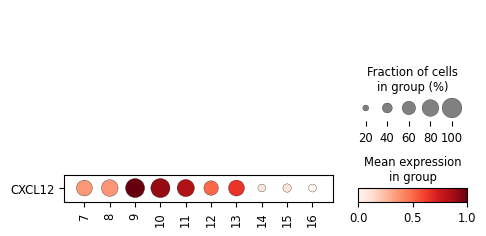

In [26]:
sc.pl.dotplot(hairfib, var_names=['CXCL12'], groupby=['pcw_new'], swap_axes=True, standard_scale='var')

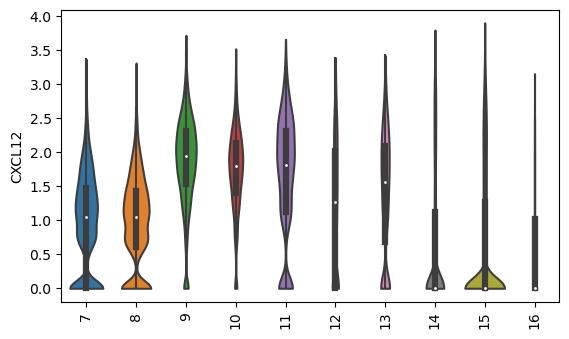

In [27]:
with rc_context({'figure.figsize' : (6,4)}):
    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='pcw_new', scale='count', use_raw=True, inner='box', rotation=90, jitter=False, 
                 stripplot=False)
#with rc_context({'figure.figsize' : (6,4)}):
#    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='pcw_new', scale='count', use_raw=True, inner='box', rotation=90, jitter=False, 
#                 stripplot=False, save='_CXCL12_28042023.pdf')

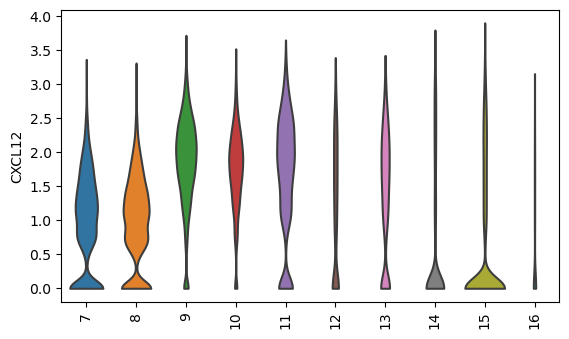

In [29]:
with rc_context({'figure.figsize' : (6,4)}):
    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='pcw_new', scale='count', use_raw=True, rotation=90, jitter=False, 
                 stripplot=False, save='_CXCL12_no_box.pdf')
#with rc_context({'figure.figsize' : (6,4)}):
#    sc.pl.violin(hairfib, keys=['CXCL12'], groupby='pcw_new', scale='count', use_raw=True, inner='box', rotation=90, jitter=False, 
#                 stripplot=False, save='_CXCL12_28042023.pdf')

# Expression of papillary fibroblast markers

In [20]:
dermal_fib = ['HOXC5+ early fibroblast',   
'WNT2+ fibroblast', 
'PEAR1+ fibroblast', 
#'FRZB+ early fibroblast'
]

In [21]:
dermalfib = adata[adata.obs['joint_annotation_20220202'].isin(dermal_fib)]

In [22]:
dermalfib

View of AnnData object with n_obs × n_vars = 48171 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'joint_annotation_20220

In [23]:
print(list(dermalfib.obs['joint_annotation_20220202'].unique()))

['WNT2+ fibroblast', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast']


In [24]:
dermalfib.obs['joint_annotation_20220202'] = dermalfib.obs['joint_annotation_20220202'].cat.reorder_categories([
#'FRZB+ early fibroblast',
'HOXC5+ early fibroblast',   
'WNT2+ fibroblast', 
'PEAR1+ fibroblast', 
])

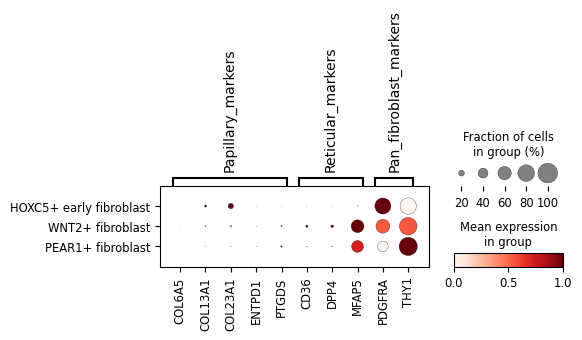

In [31]:
markers = {'Papillary_markers': ['COL6A5', 'COL13A1', 'COL23A1', 'ENTPD1', 'PTGDS'],
          'Reticular_markers': ['CD36', 'DPP4', 'MFAP5'],
          'Pan_fibroblast_markers': ['PDGFRA', 'THY1']}

sc.pl.dotplot(dermalfib, markers, groupby=['joint_annotation_20220202'], 
             standard_scale='var')

#sc.pl.dotplot(dermalfib, markers, groupby=['joint_annotation_20220202'], 
#              standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/fibroblast_markers.pdf')